In [1]:
import pandas as pd
import numpy as np
import os
import glob
from scipy.stats import pearsonr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df_br = pd.read_csv("/work/tadesse/beichen/ForDRI/Data/New_Bowen_Ratio/ameriflux_sites_fordri_US.csv", index_col=0)
df_br = df_br.drop(["Lat","Long"],axis = 1)

In [3]:
# std br list
stdBR_dir = "/work/tadesse/beichen/ForDRI/Data/New_Bowen_Ratio/ForDRI_stdBR/" # west Bowen Ratio
stdBR_list = glob.glob(stdBR_dir+"*.csv")
stdBR_list.sort()

## Annual Pearson correlation using the whole year

In [ ]:
site_list = []
r_list = []
p_list =[]
for stdBR in stdBR_list:
    fname = os.path.basename(stdBR)[:-4]
    df = pd.read_csv(stdBR,index_col=0) # get the std BR from 2003-2023
    df.loc[:,"ForDRI_Sample"] = df_br.loc[fname,df.index.values.astype(str)].values
    df = df.loc[:,["STD_Log_Bowen_ratio","ForDRI_Sample"]]
    df.columns = ['stdBR','ForDRI']
    df_forcorr = df.dropna()
    corr = pearsonr(df_forcorr.loc[:, "ForDRI"].values, df_forcorr.loc[:, "stdBR"].values)
    site_list.append(fname)
    r_list.append(round(corr[0],4))
    p_list.append(np.format_float_scientific(corr[1],  precision=4))
    # output a table of the ForDRI and BR
    df.to_csv("/work/tadesse/beichen/ForDRI/Data/New_Bowen_Ratio/ForDRI_BR/"+fname+".csv")
pearsonr_df = pd.DataFrame()
pearsonr_df["Site"] = site_list
pearsonr_df["r"] = r_list
pearsonr_df["p-value"] = p_list
print(pearsonr_df)
pearsonr_df.to_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_stdBR_PearsonR_US.csv", index = None)

## Pearson Correlation plot in growing seasong by week

In [5]:
br_fordri_dir = "/work/tadesse/beichen/ForDRI/Data/New_Bowen_Ratio/ForDRI_BR/"
br_fordri_list = glob.glob(br_fordri_dir+"*.csv")
br_fordri_list.sort()

In [ ]:
yearly_r_dict = {}
df_weekly_r = pd.DataFrame()
for f in br_fordri_list:
    fname = os.path.basename(f)[:-4]
    df = pd.read_csv(f,index_col=0)
    df = df.dropna()
    df_all_year = pd.DataFrame(columns=["stdBR","ForDRI"])
    #if fname == "US-Whs":
    #    df = df.iloc[22:,:]
    df_corr_weekly = pd.DataFrame(columns = ["pearson_r", "p_value", "AmeriFlux"])
    for week in range(18,43):
        df_week = pd.DataFrame(columns=["stdBR","ForDRI"])
        for date in df.index:
            if str(week) == str(date)[-2:]:
                df_week = pd.concat([df_week,df.loc[df.index==date,:]])
        if len(df_week.loc[:, "ForDRI"].values) >= 3:
            corr = pearsonr(df_week.loc[:, "ForDRI"].values, df_week.loc[:, "stdBR"].values)
        else:
            corr = [0,1]
        df_corr_weekly.loc[week] = [corr[0],corr[1], fname]
        df_all_year = pd.concat([df_all_year,df_week])
    yearly_r = pearsonr(df_all_year.loc[:, "ForDRI"].values, df_all_year.loc[:, "stdBR"].values)
    yearly_r_dict[fname] = yearly_r
    df_corr_weekly_005 = df_corr_weekly.loc[df_corr_weekly["p_value"]<=0.05,:]
    df_corr_weekly_nan = df_corr_weekly.loc[df_corr_weekly["pearson_r"].values==0,:]
    plt.figure(figsize = (10,5))
    plt.plot(df_corr_weekly.index.values,df_corr_weekly.pearson_r.values)
    plt.scatter(df_corr_weekly_005.index.values,df_corr_weekly_005.pearson_r.values,color="red",edgecolor="black",label = "P-value < 0.05",zorder=10,clip_on=False)
    plt.scatter(df_corr_weekly_nan.index.values,[0]*df_corr_weekly_nan.shape[0],color="black",edgecolor="black",label = "Limited Observations",zorder=10,clip_on=False)
    plt.ylim((-1,1))
    plt.ylabel("Pearson Correlation")
    plt.xlabel("Growing Season (Week)")
    plt.xticks(df_corr_weekly.index.values)
    plt.grid(axis="both")
    plt.legend()
    #plt.show()
    plt.savefig("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_BR_GrowingSeason/"+fname+".png", dpi=300)
    df_weekly_r = pd.concat([df_weekly_r,df_corr_weekly])

In [81]:
yearly_r_dict

{'PR-xGU': PearsonRResult(statistic=nan, pvalue=nan),
 'US-Akn': PearsonRResult(statistic=0.1730696348443408, pvalue=0.04806066815655308),
 'US-Bar': PearsonRResult(statistic=0.04476730289072223, pvalue=0.34828786582610477),
 'US-Cst': PearsonRResult(statistic=0.3311085118473664, pvalue=0.00018346251860419953),
 'US-EA5': PearsonRResult(statistic=0.1074704609011085, pvalue=0.4575630552732298),
 'US-GLE': PearsonRResult(statistic=-0.2475976397316473, pvalue=6.465763730393409e-07),
 'US-Ha2': PearsonRResult(statistic=0.4928339330885904, pvalue=3.591741077417409e-15),
 'US-Ho2': PearsonRResult(statistic=0.07773175488734489, pvalue=0.10666088955588257),
 'US-MMS': PearsonRResult(statistic=0.43032131465518175, pvalue=1.7049302663228386e-24),
 'US-MOz': PearsonRResult(statistic=0.6049764509884235, pvalue=2.2706482147964204e-45),
 'US-Me2': PearsonRResult(statistic=0.418074192458968, pvalue=7.613674724097924e-21),
 'US-NC2': PearsonRResult(statistic=0.3187954050554056, pvalue=7.11231457017964

## Pearson Correlation boxplot in growing seasong by week

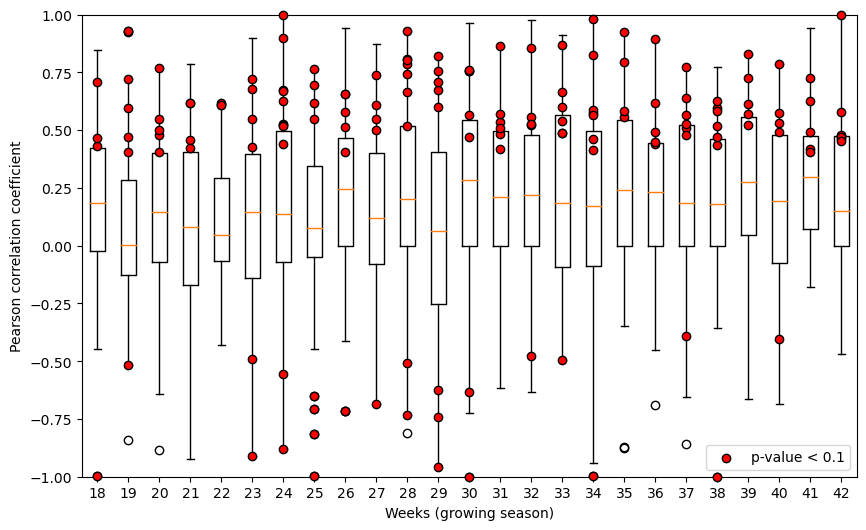

In [93]:
dicts = {}
df_weekly_r_region = df_weekly_r.copy()
df_weekly_r_region = df_weekly_r_region.dropna(axis=0)
for week in range(18,43):
    dicts[week] = df_weekly_r_region.loc[df_weekly_r_region.index == week, "pearson_r"].values
fig, ax = plt.subplots(figsize = (10,6))
ax.boxplot(dicts.values())
df_weekly_r_region_01 = df_weekly_r_region.loc[df_weekly_r_region["p_value"]<=0.1,:]
ax.scatter(df_weekly_r_region_01.index.values-17, df_weekly_r_region_01["pearson_r"].values,color="red",edgecolor="black",label = "p-value < 0.1",zorder=10,clip_on=False)
ax.set_xlabel("Weeks (growing season)")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xticklabels(dicts.keys())
ax.set_ylim((-1,1))
plt.legend()
#plt.show()
plt.savefig("/work/tadesse/beichen/Work/ForestDri/NEW_Validation_2022/New_Results/ForDRI_BR_GrowingSeason_Pearsonr_westernUS/Overall.png",dpi=300)

## Time-series plots of ForDRI and stdBR, growing seasons in shadow

In [7]:
#growing season (tentative)
gs_weeks = np.array([])
for y in range(2003,2024):
    gs_weeks = np.append(gs_weeks,np.arange(18,43,1)+(y-2003)*52)

In [9]:
corr_list = []
for f in br_fordri_list:
    fname = os.path.basename(f)[:-4]
    df = pd.read_csv(f,index_col=0)
    fig = plt.figure(figsize=(30,6))
    ax1 = fig.add_subplot(111)
    for y in range(2003,2024):
        for w in range(1,53):
            yyyyww=y*100+w
            if yyyyww not in df.index:
                df.loc[yyyyww,:]=[np.nan,np.nan]
    df.sort_index()
    ax1.plot(np.arange(0,1092,1), df["ForDRI"].values, marker = 'o',color="red", label="ForDRI")
    #ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
    fig.autofmt_xdate(rotation=90)
    ax1.set_ylim(-3.5,3.5)
    ax1.set_ylabel("ForDRI",fontsize=12)
    ax1.set_xlabel("Time (Weeks)", fontsize=12)
    plt.yticks(fontsize=12)
    ax1.set_title(fname,fontsize=14)
    for y in range(2003,2024):
        gs_weeks = np.array([18,43])+(y-2003)*52
        ax1.fill_between(gs_weeks,-3.5, 3.5,facecolor='red', alpha=0.1)
    ax1.fill_between([0,0],-3.5, 3.5,facecolor='red', alpha=0.1, label = 'Growing Season')
    ax2 = ax1.twinx()
    ax2.plot(np.arange(0,1092,1), df["stdBR"].values, marker = 'o', color="blue",label="STD Bowen Ratio")
    ax2.set_ylim(-3.5,3.5)
    #ax2.tick_params(fontsize=12)
    ax2.set_ylabel("Standardized Bowen Ratio",fontsize=12)
    #ax1.text(25,-2.5,"r = {0:.2f}, p = {1:.2e}".format(*[corr[0],corr[1]]),fontsize=12, horizontalalignment='right', verticalalignment='bottom')
    #df_growing_season = df.loc[df["Time"]==str(y)+"18":df["Time"]==str(y)+"40",:]
    corr_list.append(corr[0])
    plt.grid(axis="both")
    plt.xticks(np.arange(0,1092,14),df.index.values[6::14])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    fig.legend(ncol=3, loc='lower center')
    fig.savefig("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_BR_time_series/"+fname+'.png', dpi = 300)
    plt.close(fig)
    #fig.show()